In [9]:
from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sb
import numpy as np
from patsy import dmatrix
import sys
import os

sys.path.append(os.getcwd())
from helper import my_logit, scalling

In [10]:
df = read_excel("세미프로젝트3.xlsx")
df.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0


In [11]:
# 새로 xlsx 파일을 만드는 과성에서 컬럼 이름을 모두 처리 했기 때문에 필요 없는 코드

# df1=df.rename(columns={
#     'h1707_9':'총생활비','h1708_aq9':'이자/배당금 연간소득','h1708_aq10':'임대료 연간소득',
#     'h1708_aq26':'증여상속','h1708_4aq118':'동산/부동산 매매차익','h1708_aq30':'기타 소득',
#     'h1708_6aq3':'세금환급금','h1709_aq1':'금융기관대출','h1709_aq2':'일반사채','h1709_aq3':'카드빚',
#     'h1709_aq6':'기타부채','h1709_aq7':'주거관련 부채의 이자', 'h1706_aq3' : '주택관련_부채액',
#     'h1708_aq12' : '공적연금_연간소득' 
#     })

# df1.head()

In [12]:
#독립변수 제외 후보 컬럼 삭제하기

# df1=df1.drop(columns=['증여,상속','동산,부동산_매매차익','일반사채','카드빚','기타부채'])
# df1

for문으로 컬럼 돌려서 수치가 0인값, 0이 아닌값 찾아보기

In [13]:
df1 = df.copy()
for column in df1.columns:
    zero_count = df1.loc[df1[column] == 0].shape[0]
    number_count = df1.loc[df1[column] != 0].shape[0]
    print('0 개수 :',{column : zero_count})
    # print('0 아닌 수 :',{column : number_count})
    # print('-'*30)

0 개수 : {'총생활비': 0}
0 개수 : {'이자_배당금_연간소득': 5489}
0 개수 : {'임대료_연간소득': 6707}
0 개수 : {'기타_소득': 1439}
0 개수 : {'세금환급금': 6275}
0 개수 : {'금융기관대출': 5500}
0 개수 : {'주거관련_부채의_이자': 6414}
0 개수 : {'주택관련_부채액': 5342}
0 개수 : {'공적연금_연간소득': 4777}


# `이상치/결측치` 확인 및 처리

- 종속변수
>총생활비

- 독립변수
> '이자_배당금_연간소득','임대료_연간소득','기타_소득','세금환급금','금융기관대출'</br>
> '주거관련_부채의_이자','주택관련_부채액','공적연금_연간소득'

- 불로소득에 포함되는 변수
>이자_배당금_연간소득, 임대료_연간소득, 공적연금_연간소득

사용할 분석방법 후보

1. 피어슨 상관분석

2. 회귀분석(단순회귀,다중회귀)

3. 기타

그래프 초기화

In [15]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

In [16]:
# 그래프 생성을 위해 컬럼 이름, 길이 확인
df1.head()
df1.columns
len(df1.columns)

9

## #1. 종속/독립변수 상관관계 파악

동시에 이상치 확인

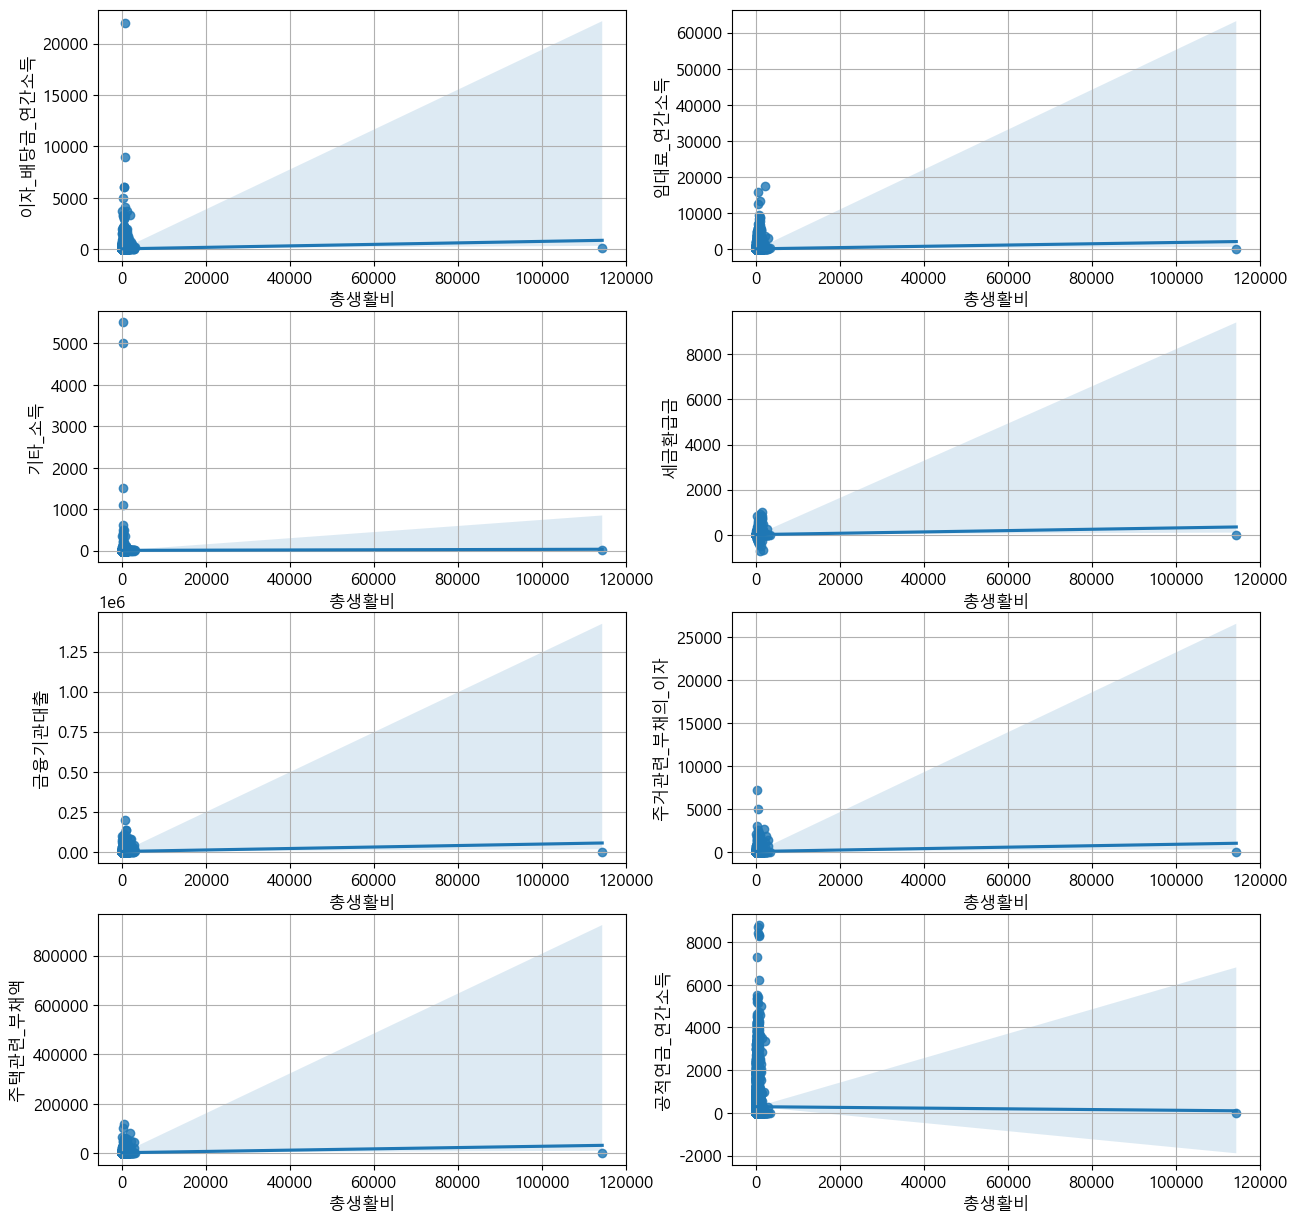

In [17]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(df1.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=df1, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid()

plt.show()
plt.close()

### `중간결과`

이상치 확인

### 총생활비의 이상치 처리

In [18]:
# 이상치의 수 확인
df1_1 = df1.copy()
df1_1=df1.query('총생활비 > 5000')
df1_1

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
1097,114446,134.0,0,8.0,0.0,0,0,0.0,0


### 이상치 행 제외하고 재조회

In [19]:
df2 = df1.copy()
df2=df1.query('총생활비 < 5000')
df2

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


In [20]:
# # 피어슨 상관분석
# r, p = stats.pearsonr(df2['총생활비'], df2['이자_배당금_연간소득'])
# r, p

In [21]:
# 반복문을 사용한 피어슨 상관분석(이상치 확인용1)
# 결측치를 중앙값으로 채우기
df2.fillna(df2.median(), inplace=True)

# 독립변수 리스트
columns = list(df2.columns)[1:]
# 종속변수
dependent_variable = '총생활비'
# 결과 저장을 위한 빈 리스트 선언
r = []
p = []

for c in columns:
    # 피어슨 상관분석 수행
    corr, p_val = stats.pearsonr(df2[dependent_variable], df2[c])
    # 결과를 리스트에 저장
    r.append(corr)
    p.append(p_val)
    # 결과 출력
    print(f"총생활비와 {c}의 피어슨 분석\n r: {corr}, p: {p_val}")

총생활비와 이자_배당금_연간소득의 피어슨 분석
 r: 0.121046871834784, p: 4.654178499633467e-27
총생활비와 임대료_연간소득의 피어슨 분석
 r: 0.18600458253331545, p: 3.7285682114474472e-62
총생활비와 기타_소득의 피어슨 분석
 r: 0.01694767175541893, p: 0.13289709160215554
총생활비와 세금환급금의 피어슨 분석
 r: 0.32827861085900784, p: 5.859782268345487e-197
총생활비와 금융기관대출의 피어슨 분석
 r: 0.3757373996477851, p: 3.55701856710652e-262
총생활비와 주거관련_부채의_이자의 피어슨 분석
 r: 0.2881525107338249, p: 3.224442018781187e-150
총생활비와 주택관련_부채액의 피어슨 분석
 r: 0.34547593624602324, p: 2.6930234727798206e-219
총생활비와 공적연금_연간소득의 피어슨 분석
 r: 0.0070523275621454246, p: 0.5317721418641598


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_7448\2517890973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.fillna(df2.median(), inplace=True)


In [22]:
# 반복문을 사용한 피어슨 상관분석(이상치 확인용1)
# 결측치가 있는 행을 삭제
df2.dropna(inplace=True)

# 독립변수 리스트
columns = list(df2.columns)[1:]
# 종속변수
dependent_variable = '총생활비'
# 결과 저장을 위한 빈 리스트 선언
r = []
p = []

for c in columns:
    # 피어슨 상관분석 수행
    corr, p_val = stats.pearsonr(df2[dependent_variable], df2[c])
    # 결과를 리스트에 저장
    r.append(corr)
    p.append(p_val)
    # 결과 출력
    print(f"총생활비와 {c}의 피어슨 분석\n r: {corr}, p: {p_val}")

총생활비와 이자_배당금_연간소득의 피어슨 분석
 r: 0.121046871834784, p: 4.654178499633467e-27
총생활비와 임대료_연간소득의 피어슨 분석
 r: 0.18600458253331545, p: 3.7285682114474472e-62
총생활비와 기타_소득의 피어슨 분석
 r: 0.01694767175541893, p: 0.13289709160215554
총생활비와 세금환급금의 피어슨 분석
 r: 0.32827861085900784, p: 5.859782268345487e-197
총생활비와 금융기관대출의 피어슨 분석
 r: 0.3757373996477851, p: 3.55701856710652e-262
총생활비와 주거관련_부채의_이자의 피어슨 분석
 r: 0.2881525107338249, p: 3.224442018781187e-150
총생활비와 주택관련_부채액의 피어슨 분석
 r: 0.34547593624602324, p: 2.6930234727798206e-219
총생활비와 공적연금_연간소득의 피어슨 분석
 r: 0.0070523275621454246, p: 0.5317721418641598


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_7448\3429624188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(inplace=True)


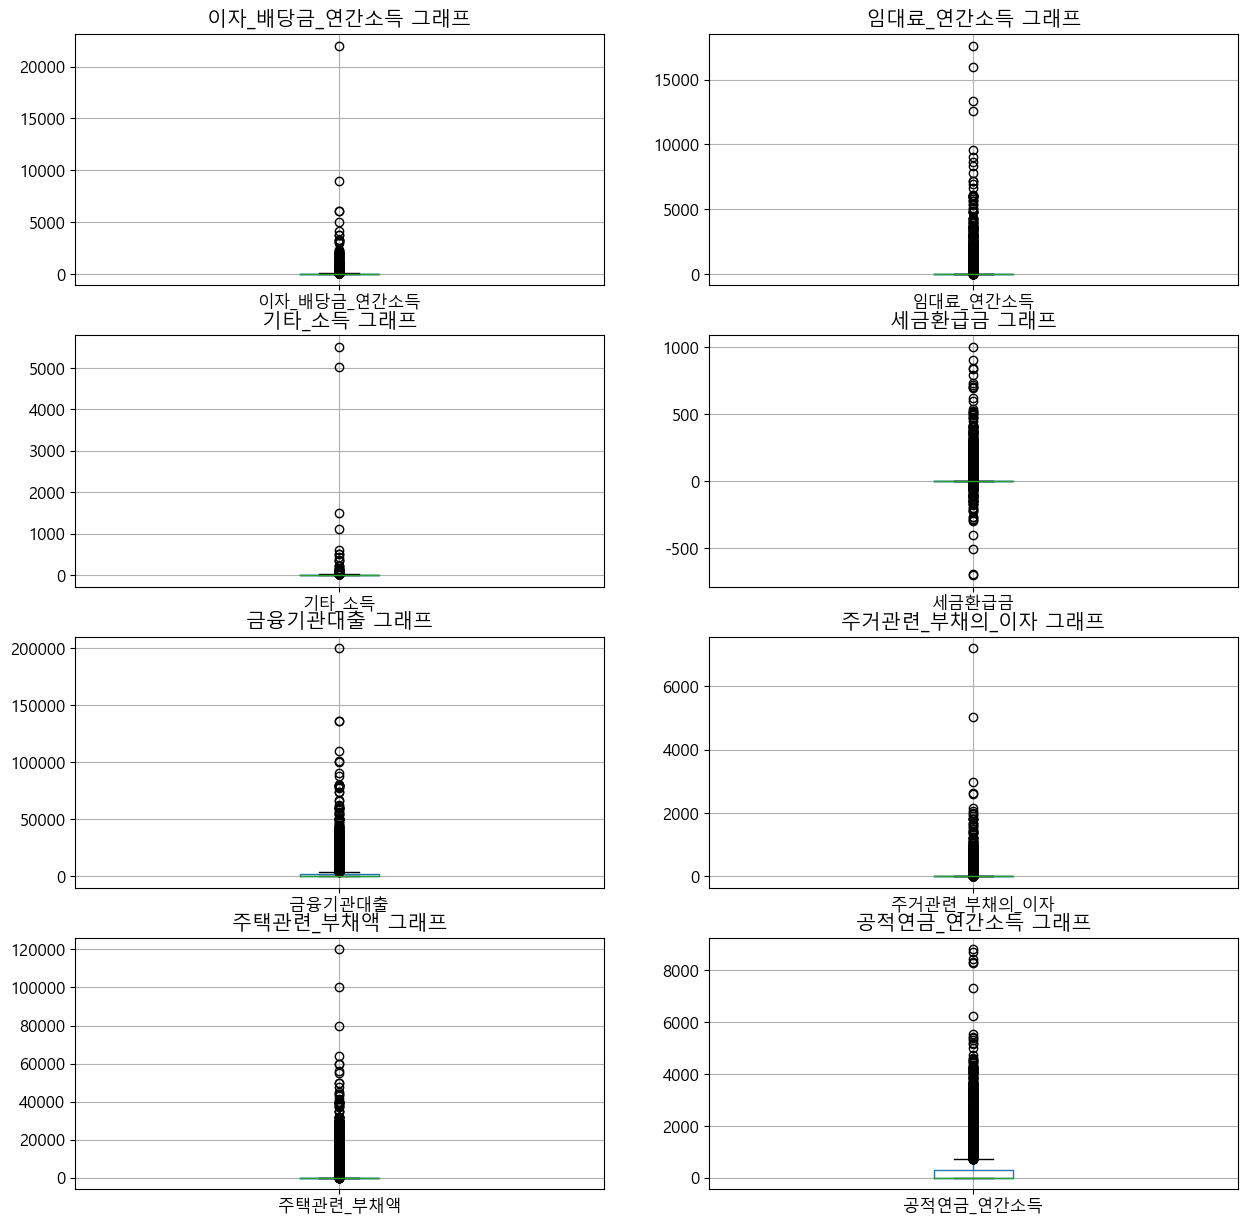

In [23]:
# 반복문을 사용한 barplot(이상치 확인용2)
# 독립변수 리스트
# columns = list(df2.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    df2.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid()
plt.grid()
plt.show()

In [24]:
df2.columns[1:]

Index(['이자_배당금_연간소득', '임대료_연간소득', '기타_소득', '세금환급금', '금융기관대출', '주거관련_부채의_이자',
       '주택관련_부채액', '공적연금_연간소득'],
      dtype='object')

In [25]:
df3 = df2.copy()
df3 = df3.query('세금환급금 > -500 and 세금환급금 < 750 and 금융기관대출 < 125000 and 주거관련_부채의_이자 < 2500')
# df3 = df3.query('금융기관대출 < 125000')
# df3 = df3.query('주거관련_부채의_이자 < 2500')
df3

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


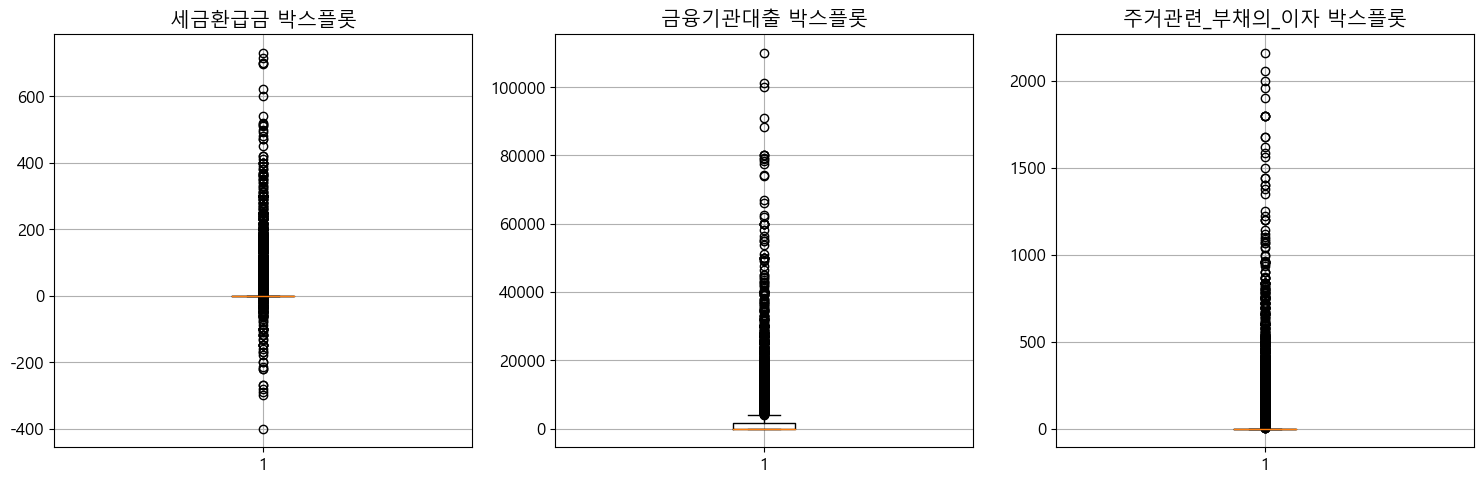

In [26]:
# 컬럼명 리스트
df3columns = ['세금환급금', '금융기관대출', '주거관련_부채의_이자']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 박스 플롯 그리기
for i, column in enumerate(df3columns):
    box_ax = ax[i]
    box_ax.boxplot(df3[column])
    box_ax.grid()
    box_ax.set_title(f'{column} 박스플롯')

# 레이아웃 조정
plt.tight_layout()
plt.show()